# Homework 5 - Group 25
## Fabio Klinge, Tom Pieper & Niklas Laasch

# What needs to be done #

1. Turn data into tensor (atm tuple) to apply preprocess()
2. Change the DenseBlock class in a way you can  alter the number
of Dense Blocks you want to use
3. Change the training part to fit both models
4. Plot this bitch


# Imports

In [1]:
# Tensorflow Imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense



# Data Preparation Imports
import numpy as np


import time


# Multiprocessing Import
import multiprocessing as mp

from tqdm import tqdm

In [2]:
# Hyperparameters
VERBOSE = True
SHUFFLE_SIZE = 1000
BATCH_SIZE = 64
PREFETCH_SIZE = 128
BUFFER_SIZE = 256

# Load Data

In [3]:
#train_ds, test_ds  = tf.keras.datasets.cifar10.load_data()
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)

# Prepare data

In [4]:
#i= 0:samples/labels 1:array containing 32 arrays 2:each 32 entries 3:1 arr each 3 integers (channels)
#print(train_ds[0][10000])

# train_images, train_labels = train_ds
# test_images, test_labels = test_ds


# Data Pipeline

In [5]:
def preprocess(data):
    # Cast Image pixel values as floats
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # Normalize pixel values
    data = data.map(lambda img, target: ((img/128 - 1), target))
    # Apply OneHot to picture labels
    data = data.map(lambda img, target: (img, tf.one_hot(target, 10)))
    # Shuffle, batch and prefetch
    data = data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
    return data
    

DONT WORK YET - by now data is saved as tuple but needs to become tensor

In [6]:


#train_ds = tf.data.Dataset.from_tensor_slices(train_ds).apply(preprocess)
#test_ds = tf.data.Dataset.from_tensor_slices(test_ds).apply(preprocess)

train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

# Layers:
---

## Feature Learning:
---
Convolution + Relu

Pooling

Convolution + Relu

Pooling

---

## Classification:
---
Flatten

Fully Connected

Softmax

---


# Model

In [7]:
# Residual Block with 3 convolutional layers
class ResidualBlock(tf.keras.Model):

    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.BatchNorm_1 = BatchNormalization()
        self.conv_1 = Conv2D(filters=16, kernel_size=3, padding="same", activation="relu")
        self.BatchNorm_2 = BatchNormalization()
        self.conv_2 = Conv2D(filters=24, kernel_size=3, padding="same", activation="relu")
        self.BatchNorm_3 = BatchNormalization()
        self.conv_3 = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")

    def call(self, inputs):
        y = self.BatchNorm_1(inputs)
        y = self.conv_1(y)
        y = self.BatchNorm_2(y)
        y = self.conv_2(y)
        y = self.BatchNorm_3(y)
        y = self.conv_3(y)

        return y + inputs



In [8]:
# Residual Network with 2 Residual blocks
class ResNet(tf.keras.Model):
    
    # 
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv_layer = Conv2D(filters=32, kernel_size=3, padding= "same", activation="relu")
        self.res_block_1 = ResidualBlock()
        self.res_block_2 = ResidualBlock()
        #dense_layer here
        self.global_pool = GlobalAveragePooling2D()
        self.out = Dense(10, activation = 'softmax')

    
    # cast the call-function as tf.function to increase efficiency
    @tf.function
    # pass the input through the layers of the network and return the output
    def call(self, inputs):
        x = self.conv_layer(inputs)
        x = self.res_block_1.call(x)
        x = self.res_block_2.call(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

In [9]:
# Transition Layer works as Bottleneck layer
class TransitionLayer(tf.keras.Model):

    def __init__(self):
        super(TransitionLayer, self).__init__()
        # Adjust filter size
        self.BatchNorm_1 = BatchNormalization()
        self.conv_layer = Conv2D(filters=16, strides=2, kernel_size=1, activation="relu", )
        self.pool_layer = AveragePooling2D(pool_size=2, strides=2)
        #self.BatchNorm_2 = BatchNormalization()

    
    # cast the call-function as tf.function to increase efficiency
    @tf.function
    # pass the input through the layers of the network and return the output
    def call(self, inputs):
        x = self.BatchNorm_1(inputs)
        x = self.conv_layer(x)
        x = self.pool_layer(x)
        #x = self.BatchNorm_2(x)
        return x

In [10]:
# Denseblock works as dense block for dense net
class DenseBlock(tf.keras.Model):


    def __init__(self, filteramount):
        super(DenseBlock, self).__init__()
        self.BatchNorm_1 = BatchNormalization()
        self.conv_1 = Conv2D(filters=filteramount, kernel_size=3, padding="same", activation="relu")
        self.BatchNorm_2 = BatchNormalization()
        self.conv_2 = Conv2D(filters=filteramount, kernel_size=3, padding="same", activation="relu")

    def call(self, inputs):
        y = self.BatchNorm_1(inputs)
        y = self.conv_1(y)
        y = self.BatchNorm_2(y)
        y = self.conv_2(y)

        return tf.keras.layers.Concatenate()([y, inputs])


In [11]:
# Dense Net Model. with 2 Dense Blocks
class DenseNet(tf.keras.Model):

    # 
    def __init__(self):
        super(DenseNet, self).__init__()
        self.conv_l = Conv2D(filters=32, kernel_size=3, padding= "same", activation="relu")
        self.dense_block_1 = DenseBlock(filteramount = 32)
        self.transition_layer_1 = TransitionLayer()
        self.dense_block_2 = DenseBlock(filteramount = 16)
        self.transition_layer_2 = TransitionLayer()
        self.BatchNorm_1 = BatchNormalization()
        self.conv_2 = Conv2D(filters=32, kernel_size=3, padding= "same", activation="relu")
        self.global_pool = GlobalAveragePooling2D()
        self.out = Dense(10, activation = 'softmax')


    # cast the call-function as tf.function to increase efficiency
    @tf.function
    # pass the input through the layers of the network and return the output
    def call(self, inputs):
        x = self.conv_l(inputs)
        x = self.dense_block_1 (x)
        x = self.transition_layer_1(x)
        x = self.dense_block_2 (x)
        x = self.transition_layer_2(x)
        x = self.BatchNorm_1(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

In [12]:
tf.keras.backend.clear_session()

# Training

## Train step & test

In [13]:
# compute the loss of an input for the model and optimize/tweak according the parameters
def train_step(model, input, target, loss_function, optimizer):
    # use tf.gradientTape to compute loss, then gradients and apply these to the model to modify the parameters
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# compute the differences between or model prediction and the label, -> Supervision
def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:

    prediction = model(input)
    
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
# for all input and computed losses get the mean of accuracy and loss and return them
  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

## Training

In [14]:
#predefine learning-rate and epochs
num_epochs = 10
#alpha = 0.1

# create a model
model = ResNet()

# define loss-function and optimizer
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# create empty arrays to store test/accuracy values, to track the network progress
train_losses = []
test_losses = []
test_accuracies = []

# get initial accuracy- and loss valus before training starts
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

print("Starting Training ResNet: ")
# training loop
average_time = []
for epoch in range(num_epochs):
    # print accuracy of each epoch
    pre_train_time = time.time()
    print(f'Epoch: {str(epoch)} starting with accuracy {str(test_accuracies[-1])}')
    
    loss_epoch = []
    # for all input, do a forwardstep and obtain loss
    for input, target in tqdm(train_ds):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        loss_epoch.append(train_loss)
    # get the mean loss of this epoch by using reduce_sum of TF over all input-losses and appending to the array  
    train_losses.append(tf.reduce_mean(loss_epoch))
    
    # get the losses and accuracy of this epoch and store them
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    average_time.append(time.time() - pre_train_time)
    print("Took: " + str(time.time() - pre_train_time))
    
# print accuracy after 10 epochs
print(test_accuracies[-1])
print("Mean Time per Epoch: " + str(round(np.mean(average_time), 2)) + "! With Parameters: ")
print("Batch size: " + str(BATCH_SIZE) + "  Prefetch size: " + str(PREFETCH_SIZE) + "  Buffer size: " + str(BUFFER_SIZE))


Starting Training ResNet: 
Epoch: 0 starting with accuracy tf.Tensor(0.10270700636942676, shape=(), dtype=float64)


100%|██████████| 782/782 [00:13<00:00, 56.60it/s]


Took: 14.513080835342407
Epoch: 1 starting with accuracy tf.Tensor(0.3837579617834395, shape=(), dtype=float64)


100%|██████████| 782/782 [00:13<00:00, 59.58it/s]


Took: 13.81011438369751
Epoch: 2 starting with accuracy tf.Tensor(0.47701035031847133, shape=(), dtype=float64)


100%|██████████| 782/782 [00:13<00:00, 59.53it/s]


Took: 13.820789813995361
Epoch: 3 starting with accuracy tf.Tensor(0.511843152866242, shape=(), dtype=float64)


100%|██████████| 782/782 [00:12<00:00, 61.32it/s]


Took: 13.378622055053711
Epoch: 4 starting with accuracy tf.Tensor(0.5727507961783439, shape=(), dtype=float64)


100%|██████████| 782/782 [00:12<00:00, 64.19it/s]


Took: 12.817049741744995
Epoch: 5 starting with accuracy tf.Tensor(0.6044984076433121, shape=(), dtype=float64)


100%|██████████| 782/782 [00:12<00:00, 63.73it/s]


Took: 12.888341903686523
Epoch: 6 starting with accuracy tf.Tensor(0.6089769108280255, shape=(), dtype=float64)


100%|██████████| 782/782 [00:12<00:00, 64.82it/s]


Took: 12.68470311164856
Epoch: 7 starting with accuracy tf.Tensor(0.6262937898089171, shape=(), dtype=float64)


100%|██████████| 782/782 [00:12<00:00, 64.98it/s]


Took: 12.654455423355103
Epoch: 8 starting with accuracy tf.Tensor(0.6432125796178344, shape=(), dtype=float64)


100%|██████████| 782/782 [00:12<00:00, 64.87it/s]


Took: 12.68404483795166
Epoch: 9 starting with accuracy tf.Tensor(0.6503781847133758, shape=(), dtype=float64)


100%|██████████| 782/782 [00:12<00:00, 64.39it/s]


Took: 12.762571811676025
tf.Tensor(0.6381369426751592, shape=(), dtype=float64)
Mean Time per Epoch: 13.2! With Parameters: 
Batch size: 64  Prefetch size: 128  Buffer size: 256


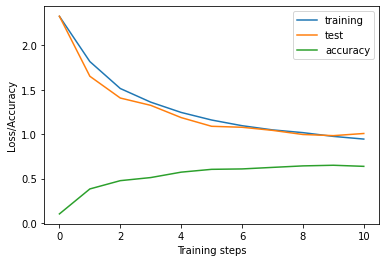

In [15]:
# Visualisation
import matplotlib.pyplot as plt

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3),("training","test", "accuracy"))
plt.show()

In [16]:
#predefine learning-rate and epochs
num_epochs = 10

# create a model
model = DenseNet()

# define loss-function and optimizer
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# create empty arrays to store test/accuracy values, to track the network progress
train_losses = []
test_losses = []
test_accuracies = []

# get initial accuracy- and loss valus before training starts
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

print("Starting Training ResNet: ")
# training loop
average_time = []
for epoch in range(num_epochs):
    # print accuracy of each epoch
    pre_train_time = time.time()
    print(f'Epoch: {str(epoch)} starting with accuracy {str(test_accuracies[-1])}')
    
    loss_epoch = []
    # for all input, do a forwardstep and obtain loss
    for input, target in tqdm(train_ds):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        loss_epoch.append(train_loss)
    # get the mean loss of this epoch by using reduce_sum of TF over all input-losses and appending to the array  
    train_losses.append(tf.reduce_mean(loss_epoch))
    
    # get the losses and accuracy of this epoch and store them
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    average_time.append(time.time() - pre_train_time)
    print("Took: " + str(time.time() - pre_train_time))
    
# print accuracy after 10 epochs
print(test_accuracies[-1])
print("Mean Time per Epoch: " + str(round(np.mean(average_time), 2)) + "! With Parameters: ")
print("Batch size: " + str(BATCH_SIZE) + "  Prefetch size: " + str(PREFETCH_SIZE) + "  Buffer size: " + str(BUFFER_SIZE))


          
    

Starting Training ResNet: 
Epoch: 0 starting with accuracy tf.Tensor(0.10011942675159236, shape=(), dtype=float64)


100%|██████████| 782/782 [00:11<00:00, 70.86it/s]


Took: 11.569739818572998
Epoch: 1 starting with accuracy tf.Tensor(0.4099323248407643, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 71.29it/s]


Took: 11.559958457946777
Epoch: 2 starting with accuracy tf.Tensor(0.47701035031847133, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 71.57it/s]


Took: 11.48751950263977
Epoch: 3 starting with accuracy tf.Tensor(0.5141321656050956, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 71.52it/s]


Took: 11.49578309059143
Epoch: 4 starting with accuracy tf.Tensor(0.5426950636942676, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 71.34it/s]


Took: 11.525977373123169
Epoch: 5 starting with accuracy tf.Tensor(0.5844944267515924, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 71.23it/s]


Took: 11.560826778411865
Epoch: 6 starting with accuracy tf.Tensor(0.5953423566878981, shape=(), dtype=float64)


100%|██████████| 782/782 [00:11<00:00, 69.23it/s]


Took: 11.904425144195557
Epoch: 7 starting with accuracy tf.Tensor(0.6191281847133758, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 71.61it/s]


Took: 11.48848009109497
Epoch: 8 starting with accuracy tf.Tensor(0.6258957006369427, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 71.28it/s]


Took: 11.545639753341675
Epoch: 9 starting with accuracy tf.Tensor(0.6388335987261147, shape=(), dtype=float64)


100%|██████████| 782/782 [00:10<00:00, 72.31it/s]


Took: 11.365231990814209
tf.Tensor(0.6390326433121019, shape=(), dtype=float64)
Mean Time per Epoch: 11.55! With Parameters: 
Batch size: 64  Prefetch size: 128  Buffer size: 256


# Visualisation

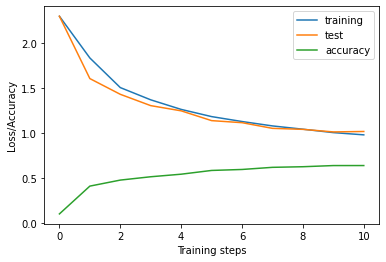

In [17]:
# Visualisation
import matplotlib.pyplot as plt

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3),("training","test", "accuracy"))
plt.show()